In [ ]:
# !pip install LightFM

In [2]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

D:\soft\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
# Int = pd.read_csv('Interactions-3.csv')
# items = pd.read_csv("items_with_text.csv")
# Int = pd.read_csv('/content/drive/MyDrive/Tehnopark/Interactions-3.csv')
# items = pd.read_csv("/content/drive/MyDrive/Tehnopark/items_with_text.csv")

In [ ]:
items["picture_url"][12]

In [ ]:
r = requests.get('https://img.mvideo.ru/Pdb/10010523b.jpg')
im = Image.open(BytesIO(r.content))
plt.imshow(im)

In [ ]:
Int["page_type"].value_counts()

In [ ]:
items.shape

In [ ]:
Int = Int.merge(items[["picture_url", "text"]].drop_duplicates(), on=["picture_url"])

In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

# Холодный старт

# Самые популярные

Посмотрим, какие товары у нас самые популярные в разных разрезах (просмотр / корзина / покупка) 

In [ ]:
class Top():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def top_items(self):
        # Хотим получить в отсортированном порядке датафрейм - product_id, user_number
        items = self.interactions[self.interactions["page_type"] == "CART"]\
                                                .groupby("product_id")["vid"].count() \
                                                .reset_index() \
                                                .sort_values("vid", ascending=False)[:30]
        
        rec_imaging(items["product_id"].values, self.product_id_to_url, items["vid"].values)

In [ ]:
T = Top(Int)

In [ ]:
T.top_items()

# Cовстречаемость

In [ ]:
Int_tmp = Int[["vid", "product_id"]].drop_duplicates()

In [ ]:
Int_tmp.head()

In [ ]:
user_products = Int_tmp.groupby(["vid"])["product_id"].apply(list).reset_index()

In [ ]:
user_products[:3]

In [ ]:
class Recomendations():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id"]].drop_duplicates()
        # Для каждого пользователя собираем товары, с которыми он взамиодействовал
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        # Считаем число товаров, с которыми взаимодействовал каждый пользователь и записываем в колонку prod_num
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        # Фильтруем пользователей, взаимодействовавших с одним товаром
        user_products = user_products[user_products["prod_num"] > 1]
        
        # Заводим словарь под товары
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            # Если товары встетились вместе больше одного раза, то добавляем в список
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [ ]:
cooc_rec = Recomendations(Int)
cooc_rec.coocurrency_count()

In [ ]:
cooc_rec.cooc_rec.sort_values("measure", ascending=False)

In [ ]:
cooc_rec.get_rec(10)

In [ ]:
cooc_rec.get_rec(121)

In [ ]:
cooc_rec.get_rec(42)

In [ ]:
cooc_rec.get_rec(1111)

In [ ]:
cooc_rec.get_rec(1236)

In [ ]:
cooc_rec.get_rec(1362)

In [ ]:
cooc_rec.get_rec(1002)

In [ ]:
cooc_rec.get_rec(1245)

In [ ]:
cooc_rec.get_rec(1247)

In [ ]:
cooc_rec.get_rec(3453)

In [ ]:
cooc_rec.get_rec(3445)

In [ ]:
cooc_rec.get_rec(667)

In [ ]:
cooc_rec.get_rec(1231)

In [ ]:
cooc_rec.get_rec(1226)

In [ ]:
cooc_rec.get_rec(1212)

In [ ]:
cooc_rec.get_rec(631)

# Content-based

In [ ]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions.drop_duplicates()
        self.content_dict = {}
        for i, j in enumerate(items["picture_url"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['text']]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["text"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [ ]:
" ".join(Int[Int["vid"] == 121]["text"])

In [ ]:
CB = Content_Based(items, Int)

In [ ]:
CB.get_items_representation()

In [ ]:
CB.get_rec_I2I(13)

In [ ]:
CB.get_rec_I2I(2145)

In [ ]:
CB.get_rec_U2I(453)

In [ ]:
CB.get_rec_U2I(333)

In [ ]:
CB.get_rec_U2I(213)

In [ ]:
CB.get_rec_U2I(777)

In [ ]:
CB.get_rec_U2I(777)

# W2V recommendations

In [ ]:
class W2V_REC():
    def __init__(self, interactions):
        self.interactions = interactions
        self.interactions["product_id"] = self.interactions["product_id"].astype(str)
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j

    def get_w2v(self):
        interactions_sentences = self.interactions.groupby(["vid"])["product_id"].apply(list).reset_index()
        self.model = gensim.models.Word2Vec(
                                        interactions_sentences["product_id"].apply(list).values,
                                        size=200,
                                        window=10,
                                        min_count=1,
                                        workers=10,
                                        iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        
    def avg_feature_vector(self, words):
        feature_vec = np.zeros(200, dtype='float32')
        n_words = 0
        for word in words:
            if word in self.index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, self.model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec
    
    def get_rec_I2I(self, i):
        i = str(i)
        metrics = [j[1] for j in self.model.wv.similar_by_word(i)]
        items = [j[0] for j in self.model.wv.similar_by_word(i)]
        print(u"Для товара")
        r = requests.get(self.content_dict[i])
        im = Image.open(BytesIO(r.content))
        plt.imshow(im)
        plt.axis('off')
        plt.show()
        print(u"Такие рекомендации")
        rec_imaging(items, self.content_dict, metrics)

    def get_rec_U2I(self, i):
        user_items = list(self.interactions[self.interactions["vid"] == i]["product_id"].drop_duplicates())
        user_emb = self.avg_feature_vector(user_items)
        recs = self.model.wv.most_similar(positive=[user_emb], topn=10)
        metrics = [j[1] for j in recs]
        items = [j[0] for j in recs]
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(user_items, self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(items, self.content_dict, metrics)

In [ ]:
w = W2V_REC(Int)
w.get_w2v()

In [ ]:
w.get_rec_I2I(0)

In [ ]:
w.get_rec_I2I(13)

In [ ]:
w.get_rec_I2I(666)

In [ ]:
w.get_rec_U2I(42)

In [ ]:
w.get_rec_U2I(4322)

In [ ]:
user = 555
CB.get_rec_U2I(user)
w.get_rec_U2I(user)

# Colloborative filtering

In [ ]:
# Для простоты положим, что вес у всех типов взаимодействий одинаковый
df_weights = pd.DataFrame({"page_type": ["PRODUCT", "CART", "PURCHASE"],
                           'weight': [1, 1, 1]})

weighted = Int.merge(df_weights, on="page_type")\
                  .groupby(["vid", "product_id", "picture_url"])["weight"]\
                  .sum()\
                  .reset_index()

In [ ]:
weighted["weight"] = (weighted["weight"] > 0).astype(int)

In [ ]:
weighted

In [ ]:
# заполним sparse матрицу
csr_rates = coo_matrix((weighted["weight"], (weighted["vid"], weighted["product_id"])), 
                    shape=(len(set(weighted["vid"])), len(set(weighted["product_id"]))))

In [ ]:
csr_rates

In [ ]:
user_rates = csr_rates.getrow(12).toarray()[0]

In [ ]:
measure = cosine_similarity([user_rates], csr_rates).reshape(-1, 1)

In [ ]:
np.sort(measure.ravel())

In [ ]:
idx = 0

In [ ]:
user_rates = csr_rates.getrow(idx).toarray()[0]
watched_items = np.where(user_rates != 0)[0]
metrics = cosine_similarity([user_rates], csr_rates).reshape(-1, 1)
# домножаем оценки пользователя на коэффициент похожести
rates = csr_matrix.multiply(csr_rates.copy(), metrics)

In [ ]:
user_rates

In [ ]:
metrics

In [ ]:
ex_df = pd.DataFrame([[1, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 1],
              [1, 1, 0, 1, 0, 1],
              [0, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 1, 1],
              [1, 1, 0, 1, 0, 1]], columns=["яблоко", "груша", "апельсин", "ананас", "кокос", "виноград"],
            index=["Вася", "Петя", "Паша", "Олег", "Марина", "Вероника"])

In [ ]:
ex_df

In [ ]:
user_rates = ex_df.iloc[1].values

In [ ]:
user_rates

In [ ]:
metrics = cosine_similarity([user_rates], ex_df.values).reshape(-1, 1)

In [ ]:
metrics

In [ ]:
rates = ex_df.values * metrics

In [ ]:
pd.DataFrame(rates, columns=["яблоко", "груша", "апельсин", "ананас", "кокос", "виноград"],
            index=["Вася", "Петя", "Паша", "Олег", "Марина", "Вероника"])

In [ ]:
total_rate = np.array(np.sum(rates, axis=0))

In [ ]:
total_rate

In [ ]:
watched_items = np.where(user_rates != 0)[0]

In [ ]:
class Colloborative():
    def __init__(self, interactions):
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = j
        df_weights = pd.DataFrame({"page_type": ["PRODUCT", "CART", "PURCHASE"],
                                   'weight': [1, 1, 1]})
        weighted = interactions.merge(df_weights, on="page_type")\
                          .groupby(["vid", "product_id", "picture_url"])["weight"]\
                          .sum()\
                          .reset_index()
        weighted["weight"] = (weighted["weight"] > 0).astype(int)
        self.csr_rates = coo_matrix((weighted["weight"], (weighted["vid"], weighted["product_id"])), 
                            shape=(len(set(weighted["vid"])), len(set(weighted["product_id"]))))
        

    def user_based(self, idx):
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        # считаем косинус между пользователем idx и всеми пользователями
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        # чтобы не рекомендовать уже просмотренные - зануляем веса просмотренных
        total_rate = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))[0]
        # печатаем рекомендации
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based(self, idx):
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        # считаем косинус между товаром idx и всеми пользователями
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()
        # печатаем рекомендации
        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])

    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

In [ ]:
clb = Colloborative(Int)

In [ ]:
# clb.user_based(0)

In [ ]:
# clb.item_based(0)

In [ ]:
# clb.item_based(12)

In [ ]:
# clb.item_based(31211)

In [ ]:
# clb.item_based(2556)

In [ ]:
# clb.item_based(404)

In [ ]:
# clb.user_based(0)

In [ ]:
# clb.user_based(404)

In [ ]:
# clb.user_based(12345)

In [ ]:
# clb.user_based(123456)

In [ ]:
# clb.user_based(34434)

In [ ]:
# clb.user_based(3333)

In [ ]:
# clb.user_based(5555)

In [ ]:
# clb.user_based(77777)

In [ ]:
# clb.user_based(5)

In [ ]:
# clb.user_based(323)

# Matrix Factorization

In [ ]:
class MatrixFactorization():
    
    def __init__(self, interactions, k):
        interactions["product_id"] = interactions["product_id"].astype(int)
        self.k = k
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j
        df_weights = pd.DataFrame({"page_type": ["PRODUCT", "CART", "PURCHASE"],
                                   'weight': [1, 1, 1]})
        weighted = interactions.merge(df_weights, on="page_type")\
                          .groupby(["vid", "product_id", "picture_url"])["weight"]\
                          .sum()\
                          .reset_index()
        weighted["weight"] = (weighted["weight"] > 0).astype(int)
        self.csr_rates = coo_matrix((weighted["weight"], (weighted["vid"], weighted["product_id"])), 
                            shape=(len(set(weighted["vid"])), len(set(weighted["product_id"]))))
        
    def MF(self):
        U, S, V = svds(self.csr_rates.astype(float), k=self.k)
        self.user_embs = U
        self.items_embs = V.T
        
    def LightFM(self):
        self.model = LightFM(loss='warp', no_components=100, learning_rate=0.03, learning_schedule="adadelta")
        self.model.fit(self.csr_rates, epochs=5, num_threads=40, verbose=True)
        self.user_feature_bias, self.user_feature_embeddings = self.model.get_user_representations()
        self.item_feature_bias, self.items_embs = self.model.get_item_representations()

    def get_rec(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))

In [ ]:
simple_svd = MatrixFactorization(Int, 30)
simple_svd.MF()

In [ ]:
# simple_svd.get_rec(122)

In [ ]:
# simple_svd.get_rec(402)

In [ ]:
# simple_svd.get_rec(10022)

In [ ]:
# simple_svd.get_rec(406)

# LightFM

In [ ]:
mf = MatrixFactorization(Int, 300)
mf.LightFM()
mf.LightFM()

In [ ]:
# mf.get_rec(406)

In [ ]:
# mf.get_rec(1234)

# ALS

$\min\limits_{q^*,p^*}\sum\limits_{u,i}(r_{ui} - q_i^Tp_u)^2 + \lambda(||q_i||^2 + ||p_u||^2)$

In [ ]:
LATENT_SIZE = 100

lambda_p = 0.2
lambda_q = 0.01

Посчитаем количество пользователей и товаров

In [ ]:
n_users = Int["vid"].value_counts().shape[0]
n_items = Int["product_id"].value_counts().shape[0]

Инициализируем латентные представления для пользователей и товаров

In [ ]:
p = 0.1 * np.random.random((n_users, LATENT_SIZE))
q = 0.1 * np.random.random((n_items, LATENT_SIZE))

In [ ]:
from collections import defaultdict

In [ ]:
df_weights = pd.DataFrame({"page_type": ["PRODUCT", "CART", "PURCHASE"],
                           'weight': [1, 5, 20]})
weighted = Int.merge(df_weights, on="page_type")\
                  .groupby(["vid", "product_id", "picture_url"])["weight"]\
                  .max()\
                  .reset_index()

In [ ]:
weighted.head()

Составим словарь взаимодействий по товару

In [ ]:
train_by_item = defaultdict(list)
for u, i, _, r in weighted.values:
    train_by_item[i].append((u, r))

Составим словарь взаимодействий по пользователю

In [ ]:
train_by_user = defaultdict(list)
for u, i, _, r in weighted.values:
    train_by_user[u].append((i, r))

Теперь составим матрицу $P$ из векторов $p_u$ и матрицу Q из векторов $q_i$. Матрицей $Q[u] \in \mathbb{R}^{n_u \times K}$ будем обозначать подматрицу матрицы $Q$ только для товаров, оцененных пользователем $u$, где $n_u$ - количество оценок пользователя $u$.

Шаг перенастройки $p_u$ при фиксированной матрице $Q$ будет выглядеть следующим образом:


$$
A_u = Q[u]^TQ[u]
$$

$$
d_u = Q[u]^Tr_u
$$

$$
p_u = (\lambda_pI + A_u)^{-1}d_u
$$


In [ ]:
def compute_p(p, q, train_by_user):
    for u, rated in train_by_user.items():
        rated_items = [i for i, _ in rated]
        Au = q[rated_items].T.dot(q[rated_items])
        ratings = [i for _, i in rated]
        du = q[rated_items].T.dot(ratings)
        p[u] = np.linalg.inv(lambda_p * np.eye(Au.shape[0]) + Au).dot(du)
    return p

Шаг для перенастройки $q_i$ при фиксированной матрице $P$ будет считаться аналогично

In [ ]:
def compute_q(p, q, train_by_item):
    for i, rated in train_by_item.items():
        rated_users = [u for u, _ in rated]
        Au = p[rated_users].T.dot(p[rated_users])
        ratings = [u for _, u in rated]
        du = p[rated_users].T.dot(ratings)
        q[i] = np.linalg.inv(lambda_q * np.eye(Au.shape[0]) + Au).dot(du)
    return q

In [ ]:
from tqdm.notebook import tqdm_notebook

In [ ]:
for i in tqdm_notebook(range(20)):
    p = compute_p(p, q, train_by_user)
    q = compute_q(p, q, train_by_item)

In [ ]:
np.save("q.npy", q)

In [ ]:
q = np.load("q.npy")

In [ ]:
product_id_to_url = {}
for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
    product_id_to_url[i[0]] = i[1]

In [ ]:
def get_rec_I2I(q, i):
    metrics = cosine_similarity([q[i]], q)
    print(u"Для товара")
    rec_imaging([i], product_id_to_url)
    print(u"Такие рекомендации")
    rec_imaging(np.argsort(metrics)[0][::-1][1:6], product_id_to_url, np.sort(metrics)[0][::-1][1:6])

In [ ]:
get_rec_I2I(q, 9343)

In [ ]:
get_rec_I2I(q, 50000)

In [ ]:
get_rec_I2I(q, 6593)

In [ ]:
get_rec_I2I(q, 1000)

# Домашнее задание

Data contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

### 1. Реализовать персональный топ  - принимает на вход возраст и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации

Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)

Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

# Жесткий дедлайн 12 мая

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.

In [36]:
books = pd.read_csv("BX-Books.csv")
# books = pd.read_csv("/content/drive/MyDrive/Tehnopark/BX-Books.csv")


D:\soft\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [37]:
interactions = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")
# interactions = pd.read_csv("/content/drive/MyDrive/Tehnopark/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [38]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [39]:
interactions

User-ID         ISBN  Book-Rating
1         276726   0155061224            5
3         276729   052165615X            3
4         276729   0521795028            6
6         276736   3257224281            8
7         276737   0600570967            6
...          ...          ...          ...
1149773   276704   0806917695            5
1149775   276704   1563526298            9
1149777   276709   0515107662           10
1149778   276721   0590442449           10
1149779   276723  05162443314            8

[433671 rows x 3 columns]

In [40]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [41]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [42]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [43]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [44]:
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')


# users = pd.read_csv('/content/drive/MyDrive/Tehnopark/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')


users.Age[(users.Age < 5) * (users.Age > 80)] = None
users.shape

D:\soft\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
<ipython-input-44-d3982ce3afdd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.Age[(users.Age < 5) * (users.Age > 80)] = None


(278858, 3)

In [45]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [46]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [47]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [48]:
interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num  \
0    86583  3404139178            9         8         18   
1   132500  3404139178           10         8         43   
2    66483  3404139178           10         8         83   
3   276866  3404139178            9         8         11   
4   106534  3404139178            6         8          6   

                                         picture_url  \
0  http://images.amazon.com/images/P/3404139178.0...   
1  http://images.amazon.com/images/P/3404139178.0...   
2  http://images.amazon.com/images/P/3404139178.0...   
3  http://images.amazon.com/images/P/3404139178.0...   
4  http://images.amazon.com/images/P/3404139178.0...   

                                    Book-Title  product_id    vid  
0  Das Lacheln der Fortuna: Historischer Roman       10397   3445  
1  Das Lacheln der Fortuna: Historischer Roman       10397   5248  
2  Das Lacheln der Fortuna: Historischer Roman       10397   2622  
3  Das Lacheln der Fortuna: Historischer Roman       10397  10887  
4  Das Lacheln der Fortuna: Historischer Roman       10397   4228

In [49]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

### Ищем id нужных книг

In [50]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)
idx: 1074 	Book Title: David Copperfield (Penguin Classics)


In [51]:
books
users
# interactions

User-ID                            Location   Age
0             1                  nyc, new york, usa   NaN
1             2           stockton, california, usa  18.0
2             3     moscow, yukon territory, russia   NaN
3             4           porto, v.n.gaia, portugal  17.0
4             5  farnborough, hants, united kingdom   NaN
...         ...                                 ...   ...
278853   278854               portland, oregon, usa   NaN
278854   278855  tacoma, washington, united kingdom  50.0
278855   278856           brampton, ontario, canada   NaN
278856   278857           knoxville, tennessee, usa   NaN
278857   278858                dublin, n/a, ireland   NaN

[278858 rows x 3 columns]

In [52]:
interactions.shape

(110519, 9)

In [53]:
users.shape

(278858, 3)

# 1) Персональный топ ( получилась коллоборативная фильтрация на минималках)

In [54]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]


In [71]:
class person_top():
    def __init__(self, users, interactions, Age = None, location = None,):
        self.users = users.copy()
        self.interactions = interactions.copy()
        self.Age = Age
        self.city = location.split(sep = ',')[0]
        self.state = location.split(sep = ',')[1]
        self.country = location.split(sep = ',')[2]
        self.users['measure'] = np.zeros_like(self.users.Location.values)
        self.users.measure += 1 * (self.users.Location.str.split(pat = ',', expand = True)[0] != self.city).values   # штраф за разные города
        self.users.measure += 2 * (self.users.Location.str.split(pat = ',', expand = True)[1] != self.state).values  # штраф за разные штаты
        self.users.measure += 3 * (self.users.Location.str.split(pat = ',', expand = True)[2] != self.country).values  # штраф за разные страны
        if self.Age is not None:
            self.users.measure[self.users.Age.notna().values] += np.abs(self.users.Age.values[self.users.Age.notna().values] - self.Age)  # штраф за разницу в возрасте
            self.users.measure[self.users.Age.isna().values] += self.users.Age[self.users.Age.notna().values].median()
        self.users['weights'] = self.users.sort_values('measure').index.to_numpy()
        self.interactions['weights'] = 1 / (self.users.iloc[interactions['User-ID'].values].weights.values + 100)  # чем более похожий читатель тем больше вес
        self.interactions['Book-Rating'] -= 5
        self.interactions['rating_new'] = self.interactions.weights.values * self.interactions['Book-Rating'].values

        info = self.interactions[{'ISBN', 'picture_url', 'Book-Title', 'product_id'}].drop_duplicates('product_id')

        rating = self.interactions.groupby('product_id')['rating_new'].sum()
        self.library = info.merge(rating, on = ['product_id']).sort_values('rating_new',  ascending=False)  # книги с рейтнгом

 

    def get_rec(self,  top = 30):
        for idx, chunk in enumerate(chunks(self.library['picture_url'].values[:top], 5)):
            # print(chunk)
            fig = plt.figure(figsize=(20, 4))
            for n, i in enumerate(chunk):
                try:
                    r = requests.get(i)
                    im = Image.open(BytesIO(r.content))
                except:
                    print('Something went wrong with {url}'.format(url=i))
                    continue
                a = fig.add_subplot(1, 5, n + 1)
                plt.imshow(im)
                plt.axis('off')
            plt.show()


In [72]:
person = person_top(users=users, interactions = interactions, Age = 10, location='nyc, new york, usa')

<ipython-input-71-b35c343d099e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.users.measure[self.users.Age.notna().values] += np.abs(self.users.Age.values[self.users.Age.notna().values] - self.Age)  # штраф за разницу в возрасте
<ipython-input-71-b35c343d099e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.users.measure[self.users.Age.isna().values] += self.users.Age[self.users.Age.notna().values].median()


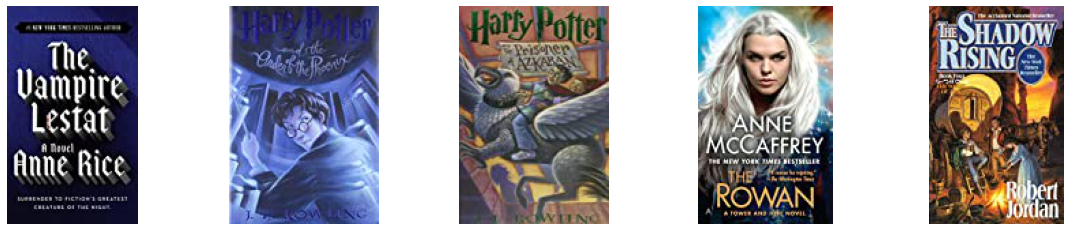

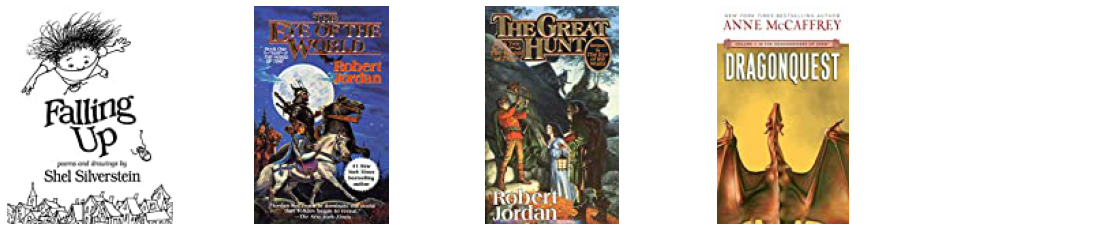

In [73]:
person.get_rec(top = 10)  

In [74]:
person.library

product_id                                         Book-Title  \
1323        1859   The Vampire Lestat (Vampire Chronicles, Book II)   
35          4233  Harry Potter and the Order of the Phoenix (Boo...   
732         4224  Harry Potter and the Prisoner of Azkaban (Book 3)   
3051        4744                    The Rowan (Ace Science Fiction)   
3283        9203      The Shadow Rising (The Wheel of Time, Book 4)   
...          ...                                                ...   
2281        1250                    The Crimson Petal and the White   
4266        2355                                 Girls' Poker Night   
2001        2172  Pandora: New Tales of the Vampires (New Tales ...   
4672         717              I Was a Teenage Fairy (Ageless Books)   
951         9730                                        Wild Animus   

                                            picture_url        ISBN  \
1323  http://images.amazon.com/images/P/0345313860.0...  0345313860   
35    http://images.amazon.com/images/P/043935806X.0...  043935806X   
732   http://images.amazon.com/images/P/0439136350.0...  0439136350   
3051  http://images.amazon.com/images/P/0441735762.0...  0441735762   
3283  http://images.amazon.com/images/P/0812513738.0...  0812513738   
...                                                 ...         ...   
2281  http://images.amazon.com/images/P/0156028778.0...  0156028778   
4266  http://images.amazon.com/images/P/0345469674.0...  0345469674   
2001  http://images.amazon.com/images/P/0345422384.0...  0345422384   
4672  http://images.amazon.com/images/P/0064408620.0...  0064408620   
951   http://images.amazon.com/images/P/0971880107.0...  0971880107   

      rating_new  
1323    0.052498  
35      0.052236  
732     0.049360  
3051    0.046762  
3283    0.046303  
...          ...  
2281   -0.001945  
4266   -0.002319  
2001   -0.002382  
4672   -0.002777  
951    -0.003983  

[10712 rows x 5 columns]

# 2) Кластеризация

In [75]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE

In [76]:
import matplotlib.colors as colors
from sklearn.mixture import GaussianMixture
colors_list = list(colors._colors_full_map.values())  # список цветов
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [77]:
class Clustering_recomendation():
    def __init__(self,interactions):
        self.Int = interactions.copy()
        self.product_id_to_url = {}
        for i in self.Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]

        csr_rates = coo_matrix((self.Int["Book-Rating"], (self.Int["vid"], self.Int["product_id"])), 
                            shape=(len(set(self.Int["vid"])), len(set(self.Int["product_id"]))))
        
        self.PCA =  PCA(n_components = 20, random_state = 4).fit(csr_rates.toarray())
        self.users = self.PCA.transform(csr_rates.toarray())

        self.EM = GaussianMixture(n_components=10, random_state=42).fit(self.users)
        self.users_idx = self.EM.predict(self.users)
        self.Int['idx'] = self.Int.vid.apply(lambda x: self.users_idx[x])


    def get_Clusterisation(self):
        colors_list = list(colors._colors_full_map.values())  # список цветов

        ts = np.vstack((self.users, self.vec_pca))
        users_idx = np.append(self.users_idx, self.idx)
        ts = TSNE(n_components=2, random_state=42).fit_transform(ts)
        
        plt.figure(figsize=(15, 10))
        plt.grid()
        for i in np.unique(users_idx):
            plt.scatter(ts[users_idx == i , 0], ts[users_idx == i, 1], cmap=colors_list[i], alpha=0.2, label = i)
        plt.scatter(ts[-1, 0], ts[-1 ,1], marker='X', s=500, label = users_idx[-1])
        plt.legend()
        plt.show() 



        
    def get_rec(self, user_id):
        user_vec = np.zeros(len(set(self.Int["product_id"])))
        user_vec[self.Int["product_id"][self.Int.vid.values == user_id]] = self.Int['Book-Rating'][self.Int.vid.values == user_id]  # вектор читателя
        user_vec = user_vec.reshape(1, -1)
        self.vec_pca = self.PCA.transform(user_vec)
        self.idx = self.EM.predict(self.vec_pca)
        item = self.Int[self.Int.idx.values == self.idx].groupby('product_id').mean()\
                                                           ['Book-Rating'].reset_index()\
                                                           .sort_values('Book-Rating', ascending=False)[:10]
        rec_imaging(item['product_id'].values, self.product_id_to_url, item['Book-Rating'].values)



In [78]:
User = Clustering_recomendation(interactions)

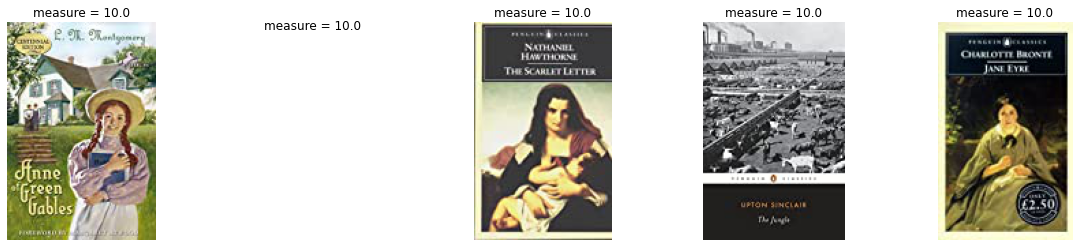

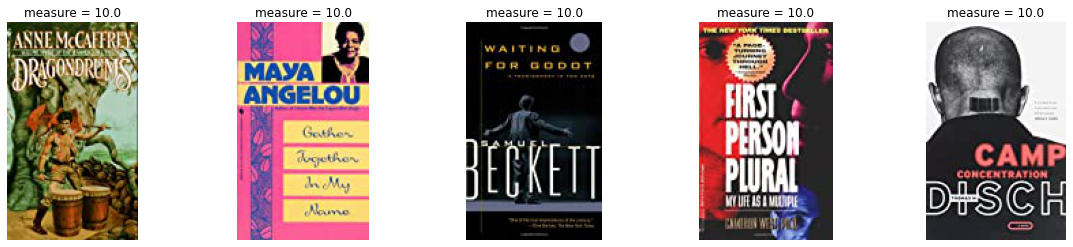

In [79]:
User.get_rec(10)

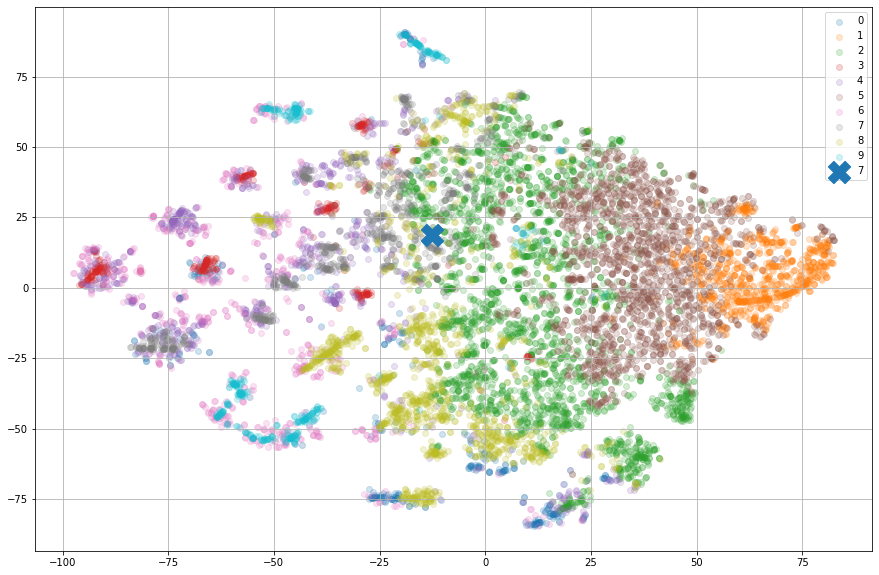

In [80]:
User.get_Clusterisation()

# 3) Совстречаемость

In [81]:
class Recomendations():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id"]].drop_duplicates()
        # Для каждого пользователя собираем товары, с которыми он взамиодействовал
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        user_products = user_products.merge(self.interactions.groupby(["vid"])["Book-Rating"].apply(list), on=['vid'])
        # Считаем число товаров, с которыми взаимодействовал каждый пользователь и записываем в колонку prod_num
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        # Фильтруем пользователей, взаимодействовавших с одним товаром
        user_products = user_products[user_products["prod_num"] > 1]
        
        # Заводим словарь под товары
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += np.array([np.mean([i[2][j], i[2][k]]), 1])
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = np.array([np.mean([i[2][j], i[2][k]]), 1])
        cooc_list = []
        for i, j in cooc.items():
            # Если товары встетились вместе больше одного раза, то добавляем в список
            if j[1] != 1:
                cooc_list.append(i.split("_") + [j[0]])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):

        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [82]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

<ipython-input-81-2a12660d0fd6>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(user_products.values):


Для товара


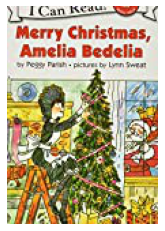

Такие рекомендации


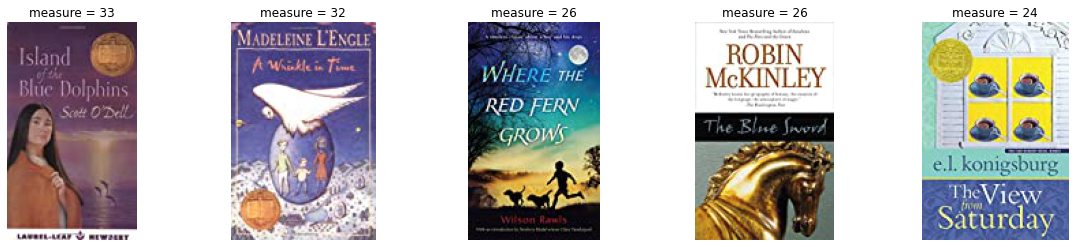

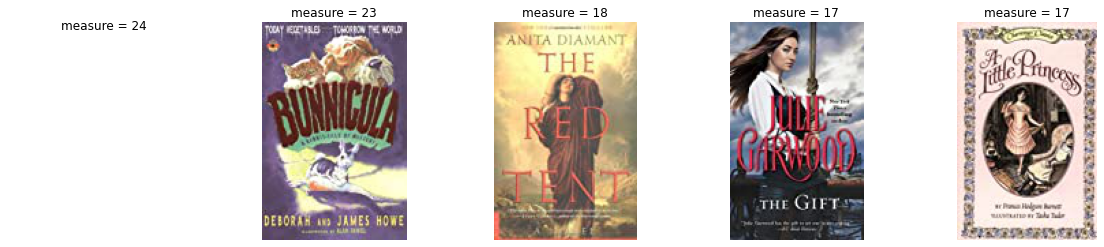

In [83]:
cooc_rec.get_rec(100)

# Content_base

In [84]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions.drop_duplicates()
        self.content_dict = {}
        for i, j in enumerate(items["Image-URL-M"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['Book-Title']]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                vector_size = 200,
#                 size=200,
                window=10,
                min_count=1,
                workers=10,
                epochs = 100)
#                 iter=100)
#         self.index2word_set = set(self.model.wv.index2word)
        self.index2word_set = set(self.model.wv.index_to_key)    
    
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["Book-Title"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [85]:
BCB = Content_Based(books, interactions)
BCB.get_items_representation()

Для товара


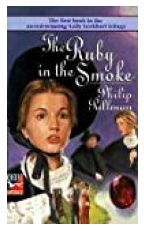

Такие рекомендации


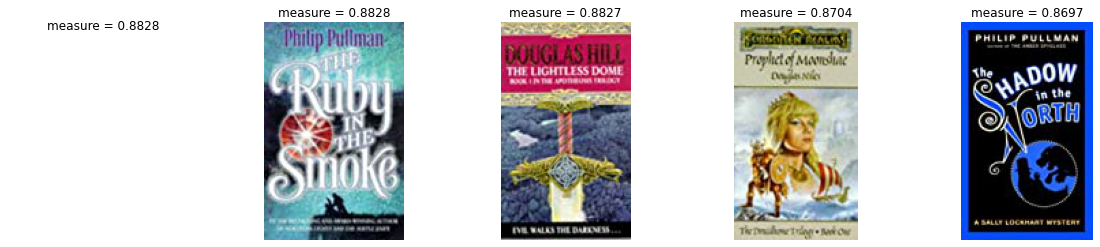

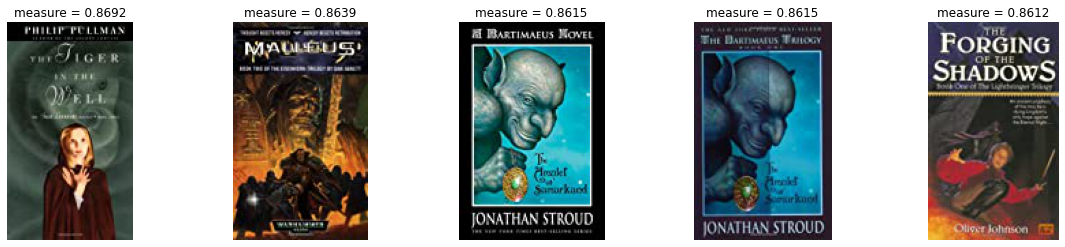

In [86]:
BCB.get_rec_I2I(78)

Для товара


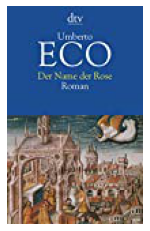

Такие рекомендации


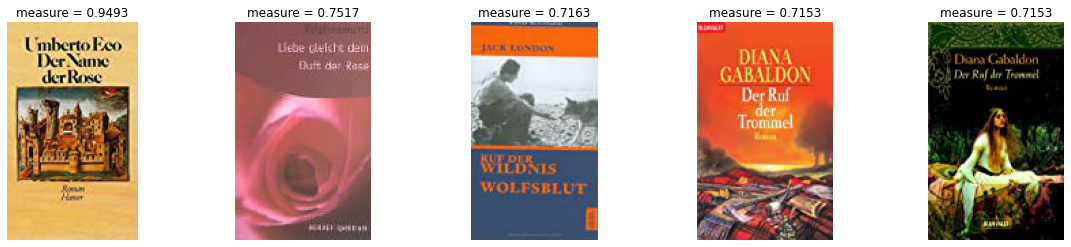

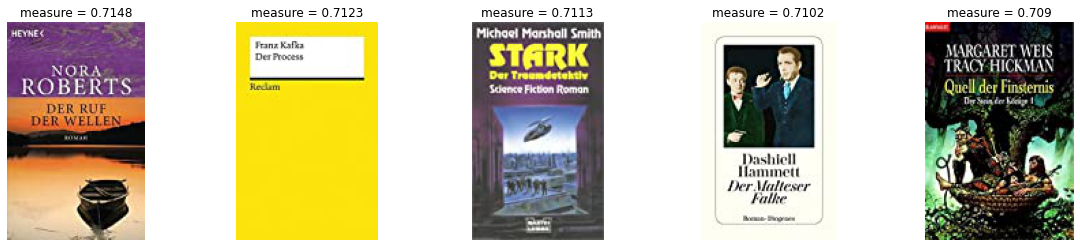

In [87]:
BCB.get_rec_I2I(87)

# Коллаборативная фильтрация

In [88]:
class Colloborative():
    def __init__(self, interactions):
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[int(i)] = j
        self.csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
        
        

    def user_based(self, idx):
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        # считаем косинус между пользователем idx и всеми пользователями
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        rates = np.mean(user_rates) + np.array(np.sum(rates, axis=0))[0] / np.sum(metrics, axis=0)
        # чтобы не рекомендовать уже просмотренные - зануляем веса просмотренных
        total_rate = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))[0]
        # печатаем рекомендации
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based(self, idx):
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        # считаем косинус между товаром idx и всеми пользователями
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        # домножаем оценки пользователя на коэффициент похожести
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.mean(item_rates) + np.array(np.sum(rates, axis=1))[:, 0]/np.sum(metrics)
        # печатаем рекомендации
        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])

    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

Для таких товаров


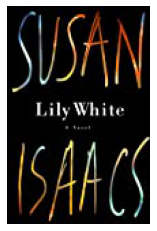

Такие рекомендации


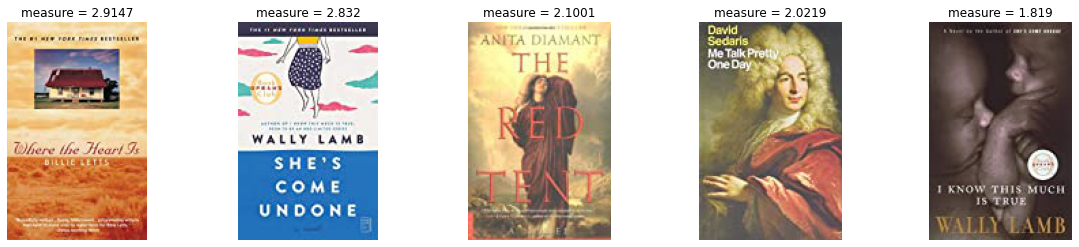

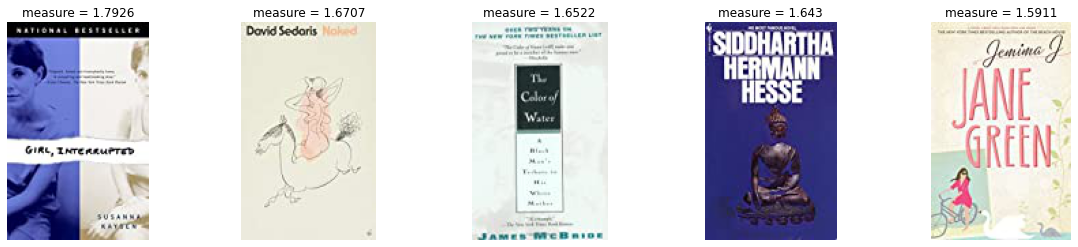

In [89]:
book_clb = Colloborative(interactions)
book_clb.item_based(120)

Для таких товаров


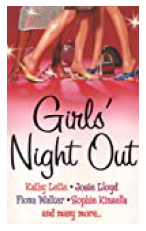

Такие рекомендации


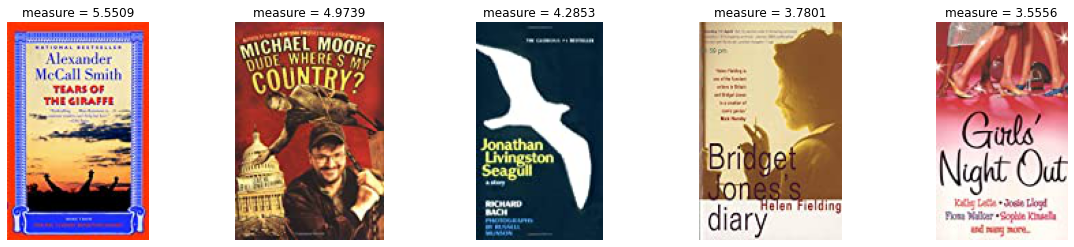

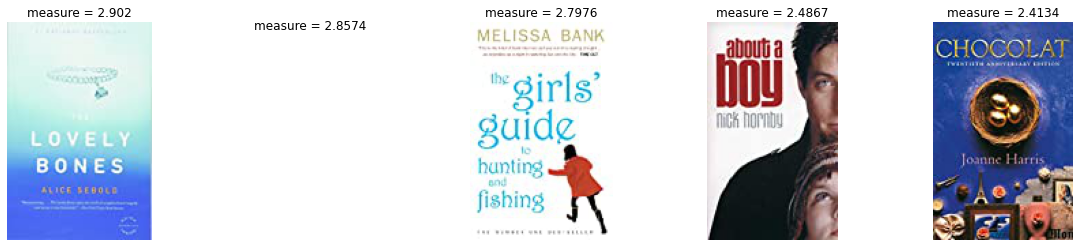

In [90]:
book_clb.item_based(14)

# Матричная факторизация

In [96]:
class Books_MatrixFactorization():  
    def __init__(self, interactions, k):
        self.k = k
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j
        self.csr_rates = coo_matrix((interactions["Book-Rating"], 
                                     (interactions["vid"], 
                                      interactions["product_id"])), 
                                    shape=(len(set(interactions["vid"])), 
                                           len(set(interactions["product_id"]))))
        
    def MF_UI(self):
        U, S, V = svds(self.csr_rates.astype(float), k=self.k)
        self.user_embs_UI = U
        self.items_embs_UI = V.T

    def MF_IU(self):
        U, S, V = svds(self.csr_rates.astype(float).T, k=self.k)
        self.items_embs_IU = U
        self.users_embs_IU = V.T        
        
    def get_rec_UI(self, i):
        metrics = cosine_similarity([self.items_embs_UI[i]], self.items_embs_UI)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))
        
        
        
    def get_rec_IU(self, i):
        metrics = cosine_similarity([self.users_embs_IU[i]], self.users_embs_IU)
        print(u"Для пользователя", i)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))

In [97]:
book_simple_svd = Books_MatrixFactorization(interactions, 30)
book_simple_svd.MF_UI()

Для товара


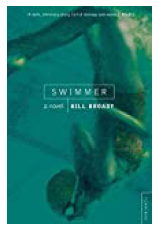

Такие рекомендации


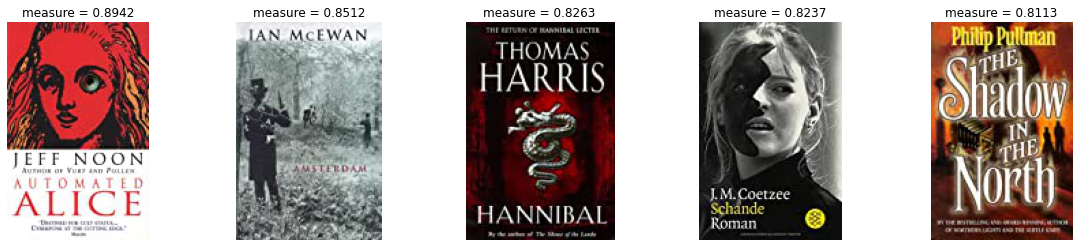

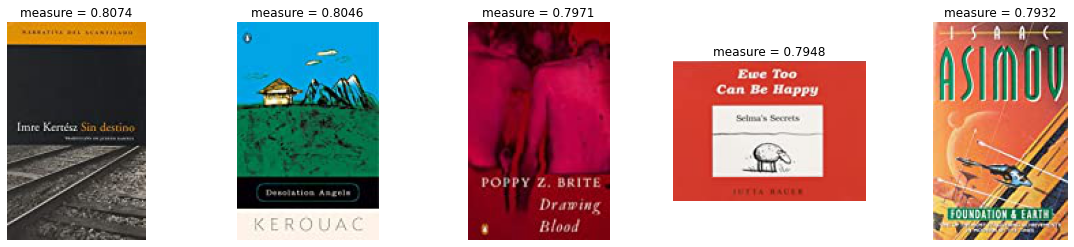

In [98]:
book_simple_svd.get_rec_UI(11)

In [99]:
book_simple_svd.MF_IU()

Для пользователя 11
Такие рекомендации


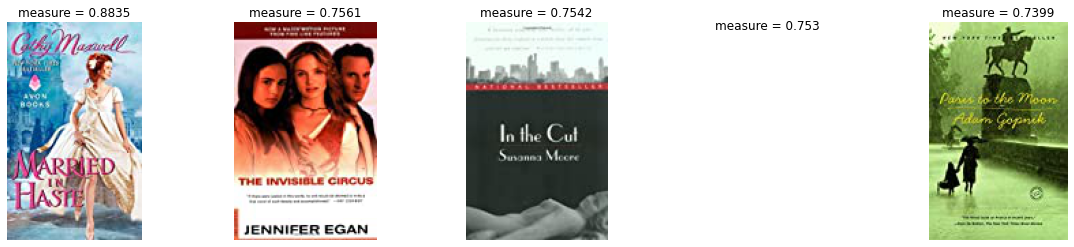

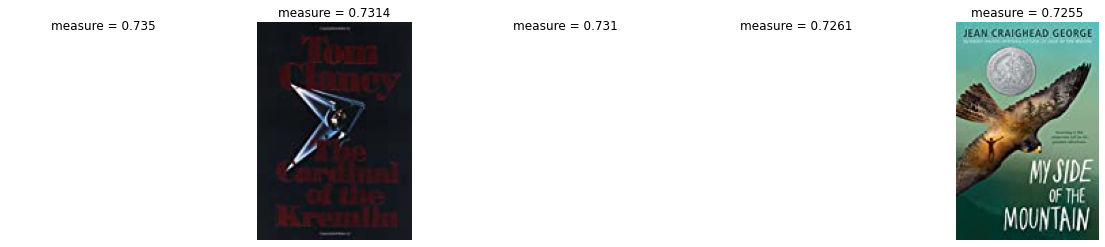

In [100]:
book_simple_svd.get_rec_IU(11)